In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby
from event_detection_ap import score, ParticipantVisibleError

In [2]:
train = pd.read_parquet("processed/final_dataset.parquet")

In [3]:
len(train)


23060846

In [4]:
def make_features(df):
    print("🔄 Starting feature generation...")

    # === 1. Convert timestamp to datetime and remove timezone ===
    print("🕒 Converting timestamp to datetime...")
    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))

    # === 2. Hour-based features ===
    print("⏰ Generating time-based features...")
    df["hour"] = df["timestamp"].dt.hour.astype('int8')
    df["minute"] = df["timestamp"].dt.minute.astype('int8')
    df["day_of_week"] = df["timestamp"].dt.dayofweek.astype('int8')
    df["elapsed_time_from_midnight"] = (df["hour"] * 60 + df["minute"]).astype('int32')
    df["is_weekend"] = (df["day_of_week"] >= 5).astype('int8')
    df["is_night"] = ((df["hour"] >= 22) | (df["hour"] <= 6)).astype('int8')

    # === 3. Time-based features ===
    print("📈 Calculating time-differential features...")
    periods = 20
    df["anglez"] = abs(df["anglez"])
    df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).bfill().astype('float16')
    df["enmo_diff"] = df.groupby('series_id')['enmo'].diff(periods=periods).bfill().astype('float16')

    # === 4. Rolling statistical features (mean, max, std, etc.) ===
    print("🔁 Computing rolling statistics...")
    window_sizes = [12, 100, 360]
    for window in window_sizes:
        print(f"  ➤ Rolling features for window size: {window}")
        for col in ['anglez', 'enmo']:
            df[f'{col}_mean_{window}s'] = df[col].rolling(window, min_periods=1).mean().astype('float16')
            df[f'{col}_std_{window}s'] = df[col].rolling(window, min_periods=1).std().astype('float16')
            df[f'{col}_min_{window}s'] = df[col].rolling(window, min_periods=1).min().astype('float16')
            df[f'{col}_max_{window}s'] = df[col].rolling(window, min_periods=1).max().astype('float16')
            df[f'{col}_median_{window}s'] = df[col].rolling(window, min_periods=1).median().astype('float16')
            df[f'{col}_cumulative_{window}s'] = df[col].rolling(window, min_periods=1).sum().astype('float16')


    # === 6. Lag Features ===
    print("⏪ Adding lag features...")
    lag_targets = [
        "anglez", "enmo",
        "anglez_mean_12s", "anglez_std_12s",
        "enmo_mean_12s", "enmo_std_12s",
        "anglez_mean_100s", "anglez_std_100s",
        "enmo_mean_100s", "enmo_std_100s"
    ]
    lag_steps = [1, 2, 3]
    for col in lag_targets:
        for lag in lag_steps:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag).astype('float16')

    # === 7. Handle NaN values ===
    print("🧹 Filling missing values...")
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].astype('float32').bfill().ffill().astype(df[numeric_cols].dtypes.to_dict())

    print("✅ Feature generation complete. Total features:", len(df.columns))

    return df

In [5]:
features = [
    "hour",
    "anglez_mean_100s",
    "anglez_std_100s",
    "anglez_diff",
    "enmo",
    "enmo_mean_100s",
    "enmo_max_100s",
    "enmo_std_100s",
    "enmo_diff"
]

In [6]:
train = make_features(train)

🔄 Starting feature generation...
🕒 Converting timestamp to datetime...
⏰ Generating time-based features...
📈 Calculating time-differential features...
🔁 Computing rolling statistics...
  ➤ Rolling features for window size: 12
  ➤ Rolling features for window size: 100
  ➤ Rolling features for window size: 360
🧠 Engineering delta and SMA features...
⏪ Adding lag features...
🧹 Filling missing values...
✅ Feature generation complete. Total features: 84


In [7]:
def showcor(X):
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title("Feature Correlation Heatmap (with values)")
    plt.show()

In [8]:
def run_cv_random_forest(train_df, features, n_splits=3, model_params=None):
    if model_params is None:
        model_params = {
            'n_estimators': 100,
            'min_samples_leaf': 300,
            'random_state': 42,
            'n_jobs': -1
        }

    X = train_df[features]
    y = train_df["awake"]
    groups = train_df["series_id"]

    gkf = GroupKFold(n_splits=n_splits)
    oof_preds = np.zeros(len(X))
    oof_preds_not_awake = np.zeros(len(X))
    feature_importances = np.zeros(X.shape[1])
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
        print(f"\n🔁 Fold {fold + 1}")
        print(f"  ➤ Training size: {len(train_idx)} | Validation size: {len(val_idx)}")

        X_tr, y_tr = X.iloc[train_idx].copy(), y.iloc[train_idx].copy()
        X_val, y_val = X.iloc[val_idx].copy(), y.iloc[val_idx].copy()

        model = RandomForestClassifier(**model_params)
        model.fit(X_tr, y_tr)

        probs = model.predict_proba(X_val)
        preds = model.predict(X_val)

        oof_preds[val_idx] = probs[:, 1]
        oof_preds_not_awake[val_idx] = probs[:, 0]

        precision = precision_score(y_val, preds)
        recall = recall_score(y_val, preds)
        f1 = f1_score(y_val, preds)

        fold_metrics.append({
            'fold': fold + 1,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

        print(f"  📈 Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

        feature_importances += model.feature_importances_

    avg_importances = feature_importances / n_splits
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': avg_importances
    }).sort_values(by='importance', ascending=False)

    metrics_df = pd.DataFrame(fold_metrics)
    print("\n📊 Fold-wise metrics:\n", metrics_df)
    print(f"\n🔍 Mean F1 Score: {metrics_df['f1_score'].mean():.4f}")

    print("\n🔥 Top 10 Feature Importances:")
    print(importance_df.head(10))

    return oof_preds, oof_preds_not_awake, model, X.columns, importance_df

In [9]:
def smooth_predictions(df, awake_col="awake_pred", not_awake_col="not_awake_pred", smoothing_length=460):
    df = df.copy()
    
    df["score"] = df[awake_col].rolling(smoothing_length, center=True).mean().fillna(method="bfill").fillna(method="ffill")
    df["smooth"] = df[not_awake_col].rolling(smoothing_length, center=True).mean().fillna(method="bfill").fillna(method="ffill")
    
    # Re-binarize
    df["smooth"] = df["smooth"].round()
    
    return df

In [10]:

# Define the function to determine the onset and wakeup events
def get_event(df):
    lstCV = zip(df.series_id, df.smooth)
    lstPOI = []
    for (c, v), g in groupby(lstCV, lambda cv: (cv[0], cv[1] != 0 and not pd.isnull(cv[1]))):
        llg = sum(1 for item in g)
        if v is False:
            lstPOI.extend([0] * llg)
        else:
            lstPOI.extend(['onset'] + (llg - 2) * [0] + ['wakeup'] if llg > 1 else [0])
    return lstPOI


In [11]:

def apply_filter(result_events, step_diff_min):
    df = pd.DataFrame(result_events)
    
    # Set a threshold for valid pairings (step difference > 15000 is invalid)
    step_diff_min_threshold = step_diff_min
    
    # Sort by series_id and step
    df = df.sort_values(by=['series_id', 'step'])
    
    # Initialize a list to store valid event pairs
    valid_pairs = []
    
    # Iterate through each unique series_id and match onsets and wakeups
    for series_id in df['series_id'].unique():
        series_data = df[df['series_id'] == series_id]
        
        onset_event = None
        for index, row in series_data.iterrows():
            if row['event'] == 'onset':
                onset_event = row
            elif row['event'] == 'wakeup' and onset_event is not None:
                # Ensure the step difference between onset and wakeup is above the minimum threshold
                step_diff = abs(row['step'] - onset_event['step'])
                if step_diff >= step_diff_min_threshold:
                    valid_pairs.append((onset_event, row))  # Add the valid pair
                onset_event = None  # Reset for next pairing
    
    # Create a DataFrame for the valid pairs in the required format
    output_data = []
    for onset, wakeup in valid_pairs:
        output_data.append({
            'series_id': onset['series_id'],
            'step': onset['step'],
            'event': 'onset',
            'score': onset['score']
        })
        output_data.append({
            'series_id': wakeup['series_id'],
            'step': wakeup['step'],
            'event': 'wakeup',
            'score': wakeup['score']
        })
    
    # Create a DataFrame from the output data
    output_df = pd.DataFrame(output_data)
    
    # Save the results to a CSV file
    output_df.to_csv('valid_pairs_predictions.csv', index=False)
    
    print("Results saved to 'valid_pairs_predictions.csv'.")

In [12]:
def evaluate_full_pipeline():


    # Load ground truth and predictions
    solution = pd.read_csv('processed/event_cleaned_final.csv')             # Ground truth
    submission = pd.read_csv('valid_pairs_predictions.csv')                      # Your predictions from train set
    
    # Define tolerances
    tolerances = {
        "onset":  [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
        "wakeup": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
    }
    
    # Set correct column names used in your prediction file
    column_names = {
        'series_id_column_name': 'series_id',
        'time_column_name': 'step',
        'event_column_name': 'event',
        'score_column_name': 'score',  # You named the prediction confidence 'score'
    }
    
    # Run scoring
    try:
        ap_score = score(solution, submission, tolerances, **column_names)
        print(f"\n✅ Average Precision Score: {ap_score}")
    except ParticipantVisibleError as e:
        print(f"\n❌ Error: {e}")


    return ap_score

In [13]:
def plot_feature_importances(model, feature_names, top_n=None, save_path=None, title="Feature Importances"):
    import matplotlib.pyplot as plt
    import pandas as pd

    importances = model.feature_importances_
    feat_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    if top_n:
        feat_df = feat_df.head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(feat_df["feature"], feat_df["importance"])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.tight_layout()
    plt.show()

    if save_path:
        feat_df.to_csv(save_path, index=False)
        print(f"📁 Feature importances saved to: {save_path}")
    
    return feat_df

In [14]:
def main_pipeline(train, features, step_diff_min=2000, n_splits=3, model_params=None):
    print("🚀 Starting full pipeline...")

    # Step 1: Feature generation
    train_df = train
    
    # Step 2: Train model and get predictions
    oof_preds, oof_preds_not_awake, model, cols, importances = run_cv_random_forest(
        train_df, features, n_splits=n_splits, model_params=model_params
    )
    plot_feature_importances(model, cols, top_n=15, save_path="feature_importances.csv")
    # Step 3: Apply predictions and smoothing
    train_df["awake_pred"] = oof_preds
    train_df["not_awake_pred"] = oof_preds_not_awake
    train_df = smooth_predictions(train_df)

    # Step 4: Detect events
    train_df["event"] = get_event(train_df)
    train_events = train_df.loc[train_df["event"] != 0, ["series_id", "step", "event", "score"]].reset_index(drop=True)
    train_events.to_csv('result_events.csv', index=False)
    print("\n✅ Events saved to: result_events.csv")

    # Step 5: Filter onset-wakeup pairs
    apply_filter(train_events, step_diff_min=step_diff_min)

    # Step 6: Evaluate
    ap_score = evaluate_full_pipeline()
    
    return ap_score

In [15]:
from itertools import product
import pandas as pd

def parameter_sweep(train, features, param_grid, step_diff_min=2000, n_splits=3):
    results = []

    # Default-Parameter, die in jedem Modell enthalten sein sollen
    default_params = {
        'random_state': 42,
        'n_jobs': -1
    }

    keys, values = zip(*param_grid.items())
    for comb in product(*values):
        sweep_params = dict(zip(keys, comb))
        model_params = {**default_params, **sweep_params}  # Merge defaults with sweep params

        print(f"\n🔍 Running pipeline with params: {model_params}")

        try:
            ap_score = main_pipeline(
                train=train,
                features=features,
                step_diff_min=step_diff_min,
                n_splits=n_splits,
                model_params=model_params  # WICHTIG!
            )
        except Exception as e:
            print(f"❌ Failed with params {model_params}: {e}")
            ap_score = None

        results.append({
            'params': model_params,
            'ap_score': ap_score
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='ap_score', ascending=False)
    return results_df


🔍 Running pipeline with params: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 100, 'min_samples_leaf': 100}
🚀 Starting full pipeline...

🔁 Fold 1
  ➤ Training size: 15330629 | Validation size: 7730217
  📈 Precision: 0.9750 | Recall: 0.9695 | F1: 0.9723

🔁 Fold 2
  ➤ Training size: 15341741 | Validation size: 7719105
  📈 Precision: 0.9732 | Recall: 0.9529 | F1: 0.9630

🔁 Fold 3
  ➤ Training size: 15449322 | Validation size: 7611524
  📈 Precision: 0.9789 | Recall: 0.9681 | F1: 0.9735

📊 Fold-wise metrics:
    fold  precision    recall  f1_score
0     1   0.975038  0.969518  0.972270
1     2   0.973188  0.952947  0.962961
2     3   0.978892  0.968085  0.973458

🔍 Mean F1 Score: 0.9696

🔥 Top 10 Feature Importances:
             feature  importance
9      enmo_std_100s    0.246992
0               hour    0.245320
8      enmo_max_100s    0.186493
7     enmo_mean_100s    0.142089
4    anglez_std_100s    0.064006
6               enmo    0.038155
2   anglez_mean_100s    0.020830
10      

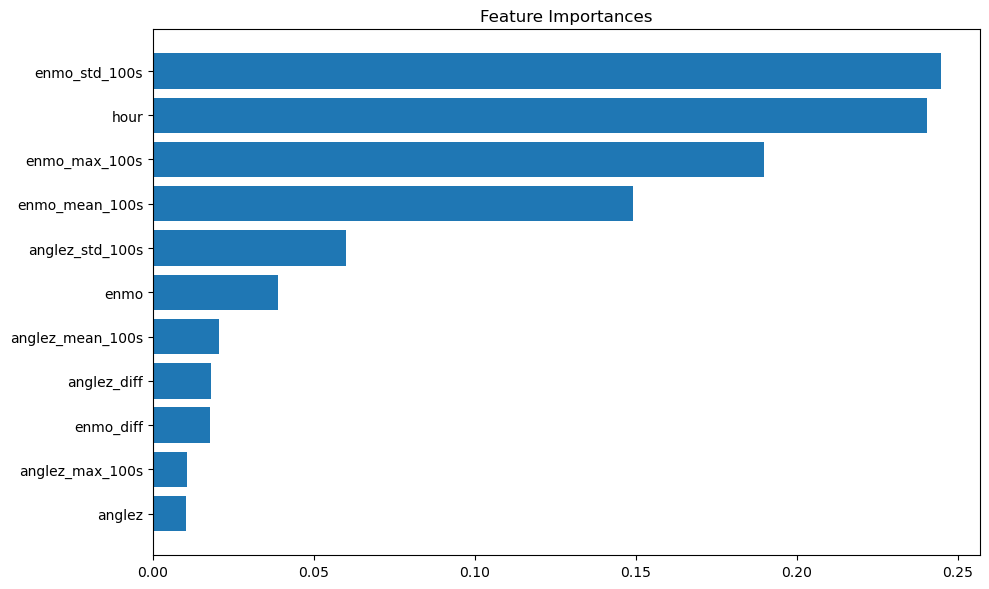

📁 Feature importances saved to: feature_importances.csv


/tmp/ipykernel_1810/3480144596.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["score"] = df[awake_col].rolling(smoothing_length, center=True).mean().fillna(method="bfill").fillna(method="ffill")
/tmp/ipykernel_1810/3480144596.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["smooth"] = df[not_awake_col].rolling(smoothing_length, center=True).mean().fillna(method="bfill").fillna(method="ffill")



✅ Events saved to: result_events.csv
Results saved to 'valid_pairs_predictions.csv'.

✅ Average Precision Score: 0.42018243662952504

🔍 Running pipeline with params: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 100, 'min_samples_leaf': 300}
🚀 Starting full pipeline...

🔁 Fold 1
  ➤ Training size: 15330629 | Validation size: 7730217
  📈 Precision: 0.9757 | Recall: 0.9688 | F1: 0.9722

🔁 Fold 2
  ➤ Training size: 15341741 | Validation size: 7719105


KeyboardInterrupt: 

In [16]:
param_grid = {
    'n_estimators': [100, 200],
    'min_samples_leaf': [100, 300],
    
}

sweep_results = parameter_sweep(train, features, param_grid)
print(sweep_results[['params', 'ap_score']])